In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import pickle
import statsmodels.api as sm
import itertools

from google.colab import files
uploaded= files.upload()

# Load the data into a pandas DataFrame called df
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')


Saving Water_dataX_mean_state_hong_kong.csv to Water_dataX_mean_state_hong_kong (3).csv


In [32]:
#df.head(1)

def data_zone_river_station (df) : 
  df=df[['water control zone','river','station','dates','wqi']]
  data = pd.DataFrame()

  B = set(df['water control zone'])
  for zone in B : 
    C = set(df[df['water control zone']==zone]['river'])
    for river in C : 
      D=set(df[df['river']==river]['station'])
      for station in D :
        subdata = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
        data = pd.concat([data, subdata])

  print(data.shape)
  data_sort = data.sort_index()
  data_sort.to_csv('data1.csv', index=False)


  # Load the data into a pandas DataFrame called df
  df_selected = pd.read_csv('data1.csv', index_col=0, parse_dates=True)

  return df_selected

def choice_of_zone_river_station (df) : 
  df=df[['water control zone','river','station','dates','wqi']]

  B = set(df['water control zone'])
  print('choisir votre zone parmi : ')    
  print(B)
  zone=input()

  C = set(df[df['water control zone']==zone]['river'])
  print('choisir votre rivier parmi ')
  print(C)
  river=input()

  D=set(df[df['river']==river]['station'])
  print('choisis votre station parmi :')
  print(D)
  station=input()

  data = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
  data.to_csv('data1.csv', index=False)
  
  # Load the data into a pandas DataFrame called df
  df_selected = pd.read_csv('data1.csv', index_col=0, parse_dates=True)
  zone_river_station = {"Selected zone = ": zone, "Selected river = ": river, "Selected station = ": station}

  return df_selected, zone_river_station

def Split_into_train_test (data_selected, coef) : 

  # Scale the data using MinMaxScaler
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(data_selected.values.reshape(-1, 1))

  # Split the data into training and testing sets
  train_size = int(len(scaled_data) * coef)
  train_data = scaled_data[:train_size, :]
  test_data = scaled_data[train_size:, :]

  return train_data, test_data, scaler, scaled_data

# Define a function to create sequences of data 
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Build the CNN model
def CNN_model(X_train) :
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=1))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=1, activation='linear'))
  return model

# Define the LSTM model
def LSTM_model(X_train) :
  model = Sequential()
  model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(LSTM(units=50))
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  return model

def ARIMA_model(train_data) :
  #parametres = AIC_PDQS(train_data)
  #print("parametres = ")
  #print(parametres['pdq'])
  #print(parametres['pdqs'])
  #model = sm.tsa.arima.ARIMA(train_data, order=parametres['pdq'],seasonal_order=parametres['pdqs'])
  #model = sm.tsa.arima.ARIMA(data_selected['wqi'], order=(1, 1, 2))
  model = sm.tsa.arima.ARIMA(train_data, order=(1, 1, 2))
  
  return model

def Choice_of_model () :
  models = {'CNN', 'LSTM', 'ARIMA'}
  print('choisir un modèle parmi : ')    
  print(models)

  choix_model=input()

  return choix_model

# Définir un callback pour mesurer les temps de chaque étape
step_times = []
class TimingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.start_time
        step_times.append(step_time)

def training_model (train_data, seq_length, choix_model, batch_size, epochs) : 

  # Create sequences of data
  X_train, y_train = create_sequences(train_data, seq_length)
  X_test, y_test = create_sequences(test_data, seq_length)
  
  # Train the model
  # Début du chrono
  start_time = time.time()
  # Enregistrer les temps de départ

  # Train the model
  if (str(choix_model)== 'ARIMA') :     
    model = ARIMA_model(train_data)
    model = model.fit()
    # save model
    model.save('model.pkl')
    history = model # a modifier
  elif (choix_model== 'CNN') :
    model = CNN_model(X_train)
    model.compile(optimizer='adam',loss='mse')
    history=model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test),callbacks=[TimingCallback()])
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  elif (choix_model== 'LSTM') :
    model = LSTM_model(X_train)
    model.compile(optimizer='adam',loss='mse')
    history=model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test),callbacks=[TimingCallback()])
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  else : 
    print("choix erroné !! ")   

  # Fin du chrono
  end_time = time.time()

  # Calcul de la durée d'entraînement en secondes
  training_time = end_time - start_time

  return model, history, training_time

def testing_model (test_data, seq_length, choix_model, model) :
  
  X_test, y_test = create_sequences(test_data, seq_length)
  y_observed = scaler.inverse_transform(y_test.reshape(-1, 1))

  prediction =[]
  # Make predictions on the test data
  if (str(choix_model)== 'ARIMA') :
    with open('model.pkl', 'rb') as pkl:
      #prediction = pickle.load(pkl).predict(start=data_selected.index[seq_length])
      #prediction = pickle.load(pkl).predict(start = X_test[0], end = X_test[len(X_test)-1])
      prediction = pickle.load(pkl).predict(start = 29001, end = 30527)
      prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
      #mse = mean_squared_error(y_observed, prediction)

      mse = mean_squared_error(test_data, prediction)
  else :
    prediction = model.predict(X_test)  ### a tester
    # Rescale the data back to the original scale
    prediction = scaler.inverse_transform(prediction)
    mse = mean_squared_error(y_observed, prediction)

  return prediction, y_observed, mse

def run_models (train_data, seq_length, batch_size, epochs) :
  predictions = dict()
  MSE = dict()
  CPU_time = dict()
  histories = dict()

  #models = {'CNN', 'ARIMA', 'LSTM'}
  models = {'CNN', 'LSTM'}
  for choice in models :
    if (choice == 'CNN') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = training_model (train_data, seq_length, choice, batch_size, epochs) 
      predictions [choice], y_observed, mse = testing_model (test_data, seq_length, choice, model)
      # la durée d'entraînement
      CPU_time [choice] = training_time
      MSE[choice] = mse
      histories[choice] = history 
    elif (choice == 'LSTM') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = training_model (train_data, seq_length, choice, batch_size, epochs)
      predictions [choice], y_observed, mse = testing_model (test_data, seq_length, choice, model)
      #la durée d'entraînement
      CPU_time [choice] = training_time
      MSE[choice] = mse
      histories[choice] = history 
    elif (choice == 'ARIMA') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = training_model(train_data, seq_length, choice, batch_size, epochs) 
      predictions [choice], y_observed, mse = np.array(testing_model(test_data, seq_length, choice, model)).reshape(-1, 1)
      #la durée d'entraînement
      CPU_time [choice] = training_time
      MSE[choice] = mse
      histories[choice] = history 
    else : 
      print("choix erroné !! ")

  return predictions, y_observed, MSE, CPU_time, histories

def plot_predictions (predictions, y_observed) :

  fig, ax = plt.subplots(3, 1, figsize=(12, 10) , height_ratios=[2, 2, 2])
  fig.subplots_adjust(hspace=0.3)

  # Data observed 
  #y_observed = scaler.inverse_transform(scaled_data[seq_length:len(scaled_data)])
  
  # Tracer les valeurs observées et prédites
  #models = {0:'LSTM', 1:'ARIMA', 2:'CNN'}
  models = {0:'LSTM', 2:'CNN'}
  for i in models.keys() : 
    #ax[i].plot(y_observed[0], label='Observed'). for arima model
    #ax[i].plot(predictions[models[i]][0], label='Predicted') for arima model
    ax[i].plot(y_observed, label='Observed')
    ax[i].plot(predictions[models[i]], label='Predicted')
    ax[i].set_title('Prediction with '+str(models[i]) + ' model', fontsize=16, color='blue')
    ax[i].set_ylabel('WQI')
    ax[i].legend()

  plt.show() 

def plot_erreurs (MSE, CPU_time, histories):
  
  #models = {'ARIMA', 'LSTM', 'CNN'}
  models = {'LSTM', 'CNN'}
  print('*********************************')
  for choice in models :
    print("CPU time of "+ str(choice)+ " model : ", CPU_time [choice], "secondes")
  print('*********************************')  
  for choice in models :
    print('Mean Square Erreur of ' + str(choice)+ ' model:', MSE[choice])

    #print('History ' + str(choice)+ ' model:', histories[choice])

  fig, ax = plt.subplots(3, 1, figsize=(12, 10) , height_ratios=[2, 2, 2])
  fig.subplots_adjust(hspace=0.3)

  #models = {0:'LSTM', 1:'ARIMA', 2:'CNN'}
  models = {0:'LSTM', 2:'CNN'}
  from pandas import DataFrame

  for i in models.keys()  :
    #print(histories[choice].history.keys())
    if (i==1) :
      ax[i].plot(DataFrame(histories['ARIMA'].resid)) ## vérifier l'équivalence entre residu d'Arima et loss de CNN et LSTN 
    else : 
      ax[i].plot(histories[models[i]].history['loss'])
      ax[i].plot(histories[models[i]].history['val_loss'])
      ax[i].legend(['train', 'test'], loc='upper left')

    ax[i].set_title('Loss of '+ str(models[i])+ ' model', fontsize=16, color='blue')
    ax[i].set_ylabel('loss')
    ax[i].set_xlabel('epoch')

  plt.show()

def AIC_PDQS(df): 

  # Runs grid search to return lowest AIC result for permutations of pdq/s values in range 0,2
  # df - Dataframe to analyze for best pdq/s permutation

  # Define the p, d and q parameters to take any value between 0 and 2
  p = d = q = range(0, 3) 

  # Generate all different combinations of p, q and q triplets
  pdq = list(itertools.product(p, d, q)) 

  # Generate all different combinations of seasonal p, q and q triplets 
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  ans = []

  # Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
  ind = 0
  for param in pdq:
    #param = (0, 1, 0)
    for param_seasonal in seasonal_pdq:
        try:
            model =sm.tsa.arima.ARIMA(df, order=param, seasonal_order=param_seasonal,enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit()
            ind = ind +1
            print('{} => ARIMA{}x{}12 - AIC:{}'.format(ind, param, param_seasonal, results.aic))
            
            ans.append([param, param_seasonal, results.aic])

        except:
            continue
  
  # Find the parameters with minimal AIC value
  ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
  optim = ans_df.loc[ans_df['aic'].idxmin()]
  
  return optim

############
#data_selected, zone_river_station = choice_of_zone_river_station(df)
data_selected = data_zone_river_station(df)

train_data, test_data, scaler, scaled_data = Split_into_train_test (data_selected, 0.95)
train_size = train_data.shape[0]

(30528, 2)


************** CNN model is running ********* : 
Epoch 1/3
906/906 [==============================] - 13s 12ms/step - loss: 0.0949 - val_loss: 0.0134
Epoch 2/3
906/906 [==============================] - 11s 13ms/step - loss: 0.0167 - val_loss: 0.0129
Epoch 3/3
47/47 [==============================] - 0s 3ms/step
************** LSTM model is running ********* : 
Epoch 1/3
906/906 [==============================] - 61s 62ms/step - loss: 0.0213 - val_loss: 0.0133
Epoch 2/3
906/906 [==============================] - 53s 59ms/step - loss: 0.0162 - val_loss: 0.0128
Epoch 3/3
47/47 [==============================] - 2s 17ms/step


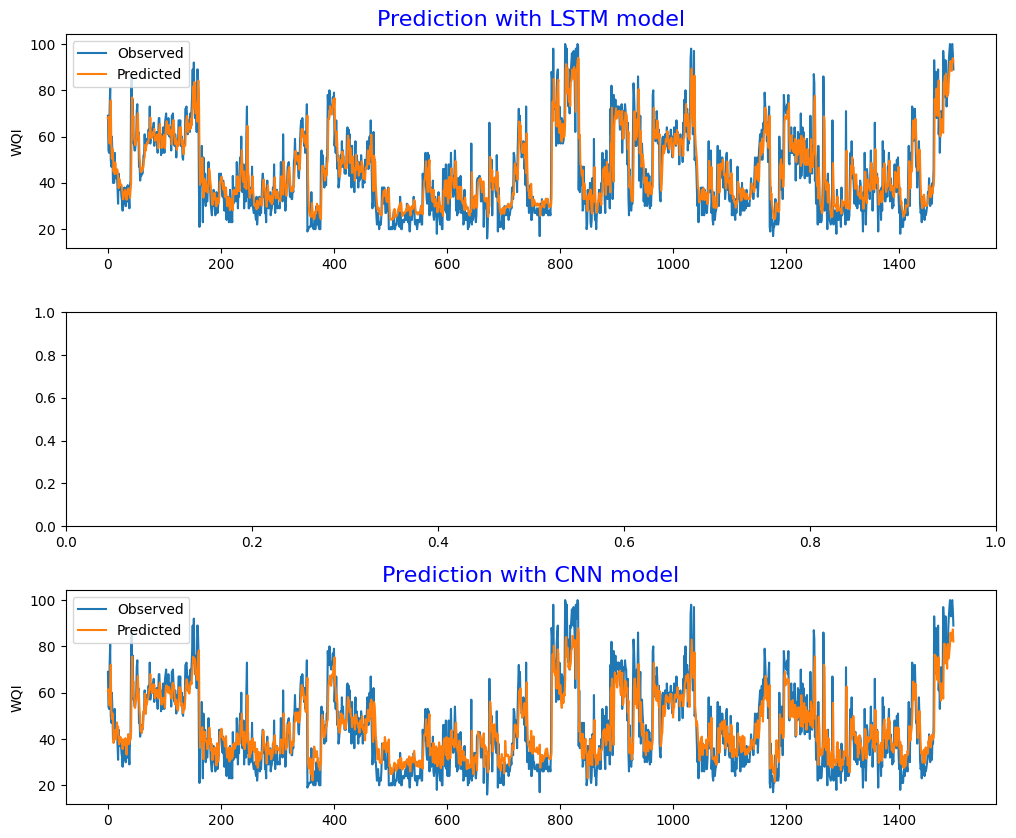

*********************************
CPU time of CNN model :  35.161351680755615 secondes
CPU time of LSTM model :  206.9712097644806 secondes
*********************************
Mean Square Erreur of CNN model: 105.19396949520119
Mean Square Erreur of LSTM model: 101.18526663113872


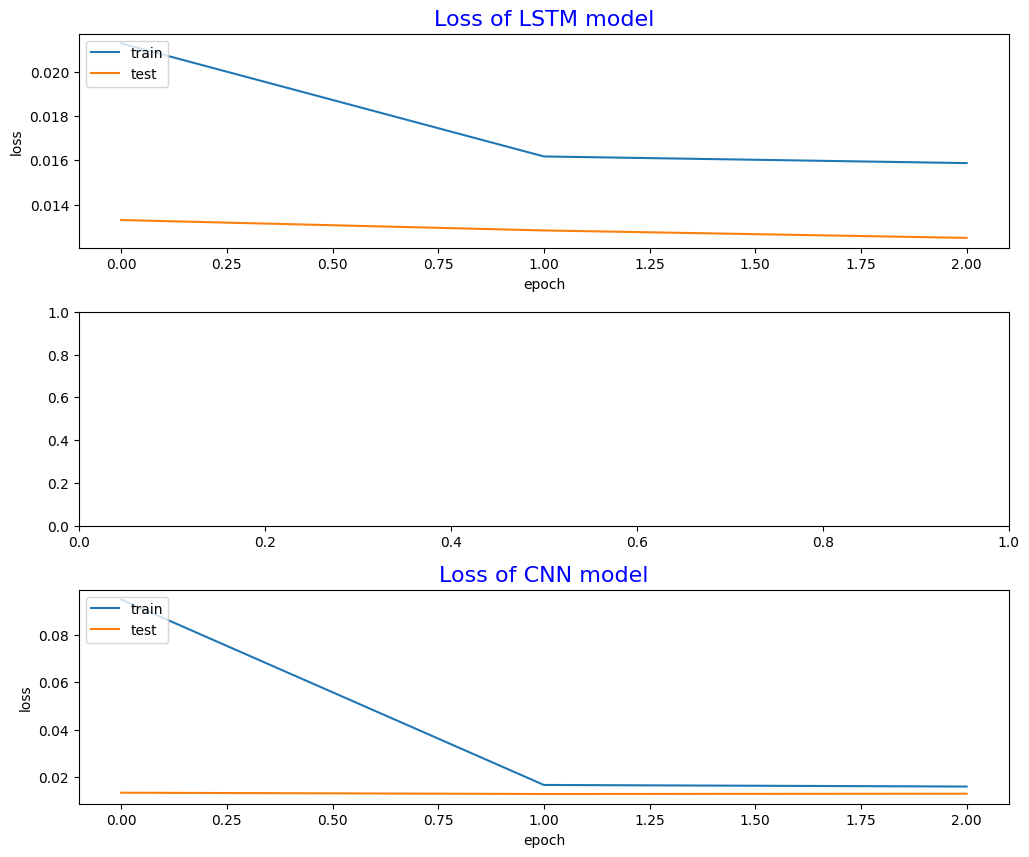

In [33]:

#model, choix_model = Choice_of_model ()

predictions, y_observed, MSE, CPU_time, histories = run_models (train_data, seq_length=30, batch_size=32,  epochs = 3)
plot_predictions (predictions, y_observed)
plot_erreurs (MSE, CPU_time, histories)



In [25]:
import statsmodels.api as sm
print(data_selected)
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()


print(len(data_selected['wqi']))
data_selected['Date'] = pd.to_datetime(data_selected['Date'])
data_selected = data_selected.set_index('Date').asfreq('D')

seasonal_decompose (data_selected['wqi'])    

              wqi
dates            
1986-04-29   62.0
1986-05-19   64.0
1986-06-18   67.0
1986-07-24   68.0
1986-08-15   68.0
...           ...
2020-07-15   93.0
2020-09-16   98.0
2020-10-07  100.0
2020-11-16   96.0
2020-12-02   89.0

[30528 rows x 1 columns]
30528


KeyError: ignored